In [26]:
import scipy
import scipy.sparse.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

# simulation grid
nu = 1
L = 35
nx = 1024//4
nt = 4000//4

# initial conditions used for demo
T  = 300
x = np.linspace( 0, L,  nx)
u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)

simulation_params = {'nu': nu, 'L': L, 'nx': nx, 'nt': nt}

# plot the result
def plot_KS(u,T,nx=nx,nt=nt):
    x = np.linspace( 0, L, nx)
    t = np.linspace( 0, T, nt)
    fig, ax = plt.subplots(figsize=(10,8))

    xx, tt = np.meshgrid(x, t)
    levels = np.linspace(-3.5, 3.5, 300)
    cs = ax.contourf(xx, tt, u, levels)
    fig.colorbar(cs)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

In [27]:
def full_integrator(nu, L, nx, nt):
  @jit
  def propagator(u0, T):
    dt = T/nt
    # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
    k = (2 * jnp.pi / L) * fftfreq(nx) * nx

    # solution mesh in real and Fourier space
    u      = jnp.empty((nt, nx), dtype=jnp.float64)
    u_hat  = jnp.empty((nt, nx), dtype=jnp.complex128)
    u_hat2 = jnp.empty((nt, nx), dtype=jnp.complex128)

    # set initial condition in real and Fourier space
    u      = u     .at[0].set( u0 )
    u_hat  = u_hat .at[0].set( (1 / nx) * fft(u[0])    )
    u_hat2 = u_hat2.at[0].set( (1 / nx) * fft(u[0]**2) )

    # Fourier Transform of the linear and nonlinear operators
    FL = (k ** 2) - nu * (k ** 4)
    FN = - (1 / 2) * (1j) * k

    # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
    CN1 = (1 + (dt / 2) * FL)
    CN2 = 1 / (1 - (dt / 2) * FL)

    # first timestep (no advanced restarting, just Euler)
    u_hat  = u_hat .at[1].set( CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt) )

    # auxiliaries of first timestep
    u      = u     .at[1].set( nx * jnp.real(ifft(u_hat[1])) )
    u_hat2 = u_hat2.at[1].set( (1 / nx) * fft(u[1]**2)       )

    # compute solution through time via finite difference method in Fourier space
    def finite_step(j, state):
        u, u_hat, u_hat2 = state
        # Cranck-Nicholson + Adams-Bashforth
        u_hat  = u_hat.at[j+1].set( CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt) )
        
        # go back to real space
        u      = u     .at[j+1].set( nx * jnp.real(ifft(u_hat[j+1])) )
        u_hat2 = u_hat2.at[j+1].set( (1 / nx) * fft(u[j+1]**2)       )
        return (u, u_hat, u_hat2)

    # compute solution through time via finite difference method in Fourier space
    u = jax.lax.fori_loop(1,nt-1,finite_step,(u, u_hat, u_hat2))[0]
    return jnp.real(u)
  
  return propagator

def integrator(nu, L, nx, nt):
  @jit
  def propagator(u0, T):
      dt = T/nt
      
      # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
      k = (2 * jnp.pi / L) * fftfreq(nx) * nx

      # Fourier Transform of the linear and nonlinear operators
      FL = (k ** 2) - nu * (k ** 4)
      FN = - (1 / 2) * (1j) * k

      # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
      CN1 = (1 + (dt / 2) * FL)
      CN2 = 1 / (1 - (dt / 2) * FL)

      # set initial condition in real and Fourier space
      u      = jnp.float64(u0)
      u_hat  = jnp.complex128((1 / nx) * fft(u0))
      u_hat2 = jnp.complex128((1 / nx) * fft(u0**2))

      # first timestep (no advanced restarting, just Euler)
      u_hatL  = CN2 * ( CN1 * u_hat + FN * u_hat2 * dt)
      uL      = nx * jnp.real(ifft(u_hatL))
      u_hat2L = (1/nx) * fft(uL**2)

      # compute solution through time via finite difference method in Fourier space
      def finite_step(j, state):
          u, u_hat, u_hat2, u_hat2L = state

          # Cranck-Nicholson + Adams-Bashforth
          u_hatN =  CN2 * ( CN1 * u_hat + ( 1.5 * FN * u_hat2 - 0.5 * FN * u_hat2L ) * dt)
          
          # go back to real space
          uN      = nx * jnp.real(ifft(u_hatN))
          u_hat2N = (1/nx) * fft(uN**2)

          return (uN, u_hatN, u_hat2N, u_hat2)

      # compute solution through time via finite difference method in Fourier space
      u = jax.lax.fori_loop(1,nt-1,finite_step,(u, u_hat, u_hat2, u_hat2L))[0]
      return jnp.real(u)
  
  return propagator

full_propagator = full_integrator(**simulation_params)
propagator = integrator(**simulation_params)

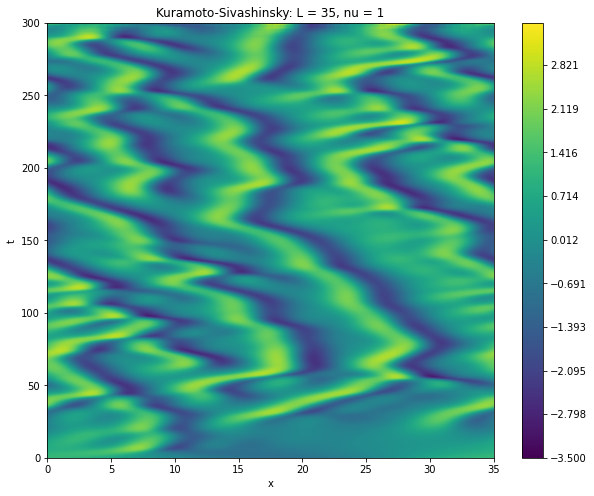

In [28]:
u = full_propagator(u0,T)
plot_KS(u,T)

In [29]:
diff = np.linalg.norm(u[:,np.newaxis] - u[np.newaxis,:],axis=-1)
X, Y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
diff[abs(X-Y)<0.1] += np.inf
#plt.contourf(diff)
#plt.colorbar()

7.654376833146577
550 727


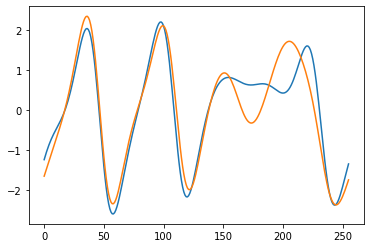

In [30]:
a = np.argmin(diff) % nt
b = np.argmin(diff) // nt
a, b = min(a,b), max(a,b)
plt.plot(u[a])
plt.plot(u[b])
print(np.linalg.norm(u[a] - u[b]))
print(a,b)

In [31]:
new_T = T * (b-a)/nt
u_new = full_propagator(u[a],new_T)
#plot_KS(u_new, new_T)

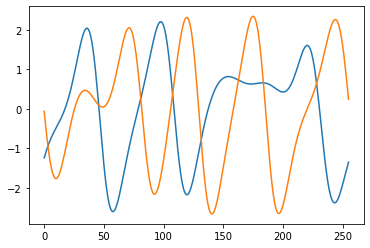

In [32]:
plt.plot(u_new[0])
plt.plot(u_new[-1])

In [33]:
@jit
def residual(u0):
    return (u0 - propagator(u0,new_T)) / jnp.linalg.norm(u0)

|F(x)| = 1.8277977509336263


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.


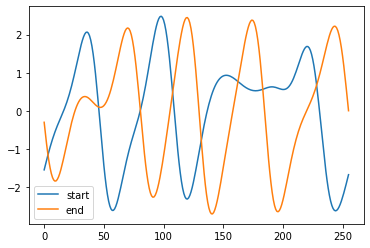

1: |F(x)| = 1.8082436544, |s| = 0.01000, |p| = 204.07979, |u| = 22.04775


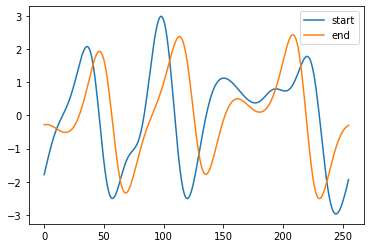

2: |F(x)| = 1.1155331401, |s| = 0.01011, |p| = 327.81564, |u| = 23.97173


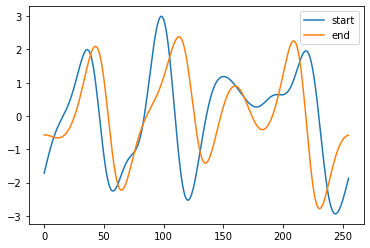

3: |F(x)| = 1.0171945924, |s| = 0.01638, |p| = 98.70160, |u| = 23.79698


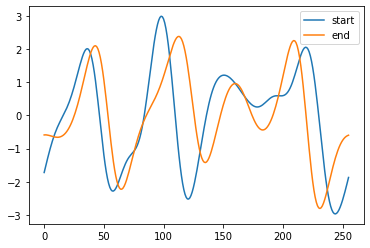

4: |F(x)| = 0.9984673597, |s| = 0.01797, |p| = 27.15959, |u| = 23.97888


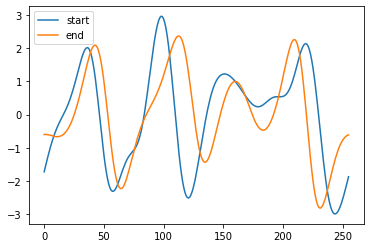

5: |F(x)| = 0.9793005405, |s| = 0.01831, |p| = 25.47648, |u| = 24.13288


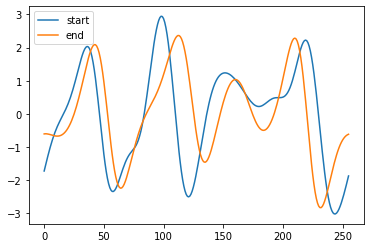

6: |F(x)| = 0.9597856385, |s| = 0.01866, |p| = 24.42840, |u| = 24.26025


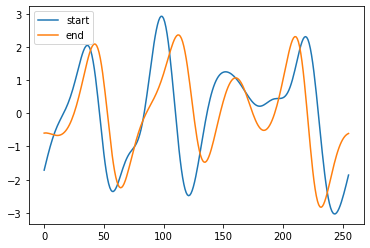

7: |F(x)| = 0.9400528189, |s| = 0.01904, |p| = 23.37140, |u| = 24.36407


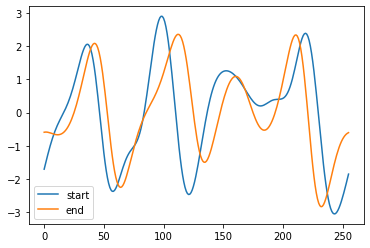

8: |F(x)| = 0.9203179761, |s| = 0.01944, |p| = 22.19724, |u| = 24.44842


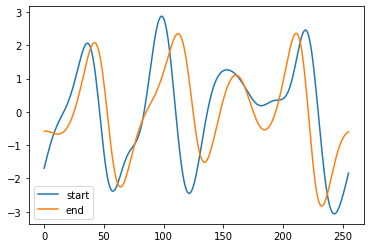

9: |F(x)| = 0.9008277961, |s| = 0.01986, |p| = 20.91550, |u| = 24.51710


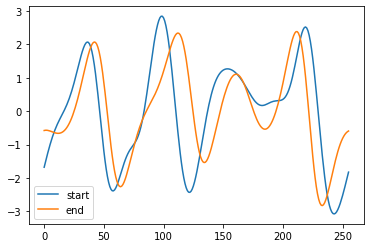

10: |F(x)| = 0.8818306561, |s| = 0.02029, |p| = 19.57886, |u| = 24.57311


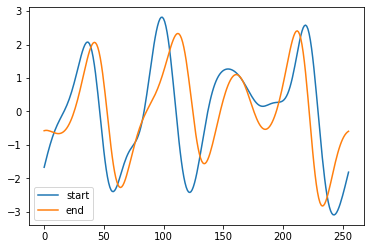

11: |F(x)| = 0.8635874345, |s| = 0.02073, |p| = 18.25175, |u| = 24.61853


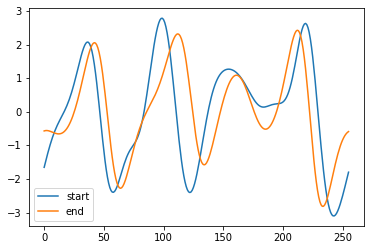

12: |F(x)| = 0.8464050285, |s| = 0.02117, |p| = 16.99429, |u| = 24.65460


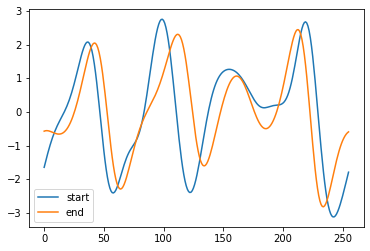

13: |F(x)| = 0.8306820590, |s| = 0.02159, |p| = 15.85636, |u| = 24.68185


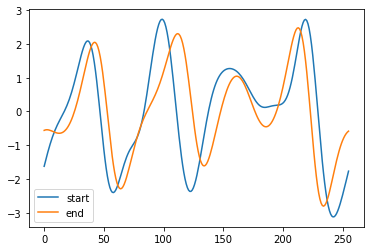

14: |F(x)| = 0.8169691734, |s| = 0.02200, |p| = 14.88065, |u| = 24.70013


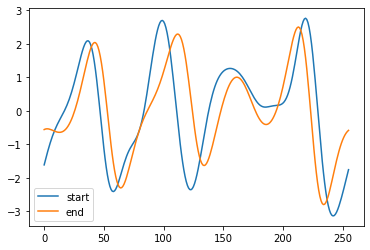

15: |F(x)| = 0.8060556564, |s| = 0.02237, |p| = 14.11144, |u| = 24.70862


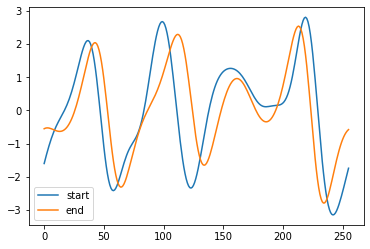

16: |F(x)| = 0.7991060710, |s| = 0.02268, |p| = 13.61435, |u| = 24.70558


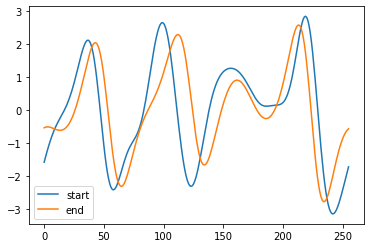

17: |F(x)| = 0.7979153923, |s| = 0.02287, |p| = 13.52474, |u| = 24.68747


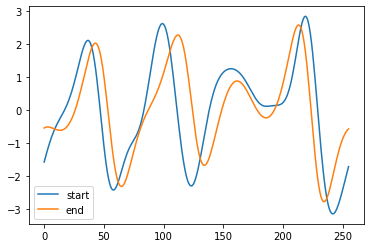

18: |F(x)| = 0.7944785088, |s| = 0.01145, |p| = 14.26254, |u| = 24.66561


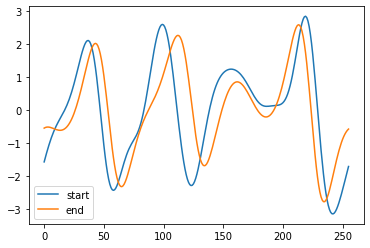

19: |F(x)| = 0.7919609112, |s| = 0.01150, |p| = 15.14114, |u| = 24.63336


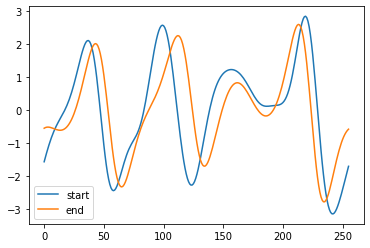

20: |F(x)| = 0.7906005095, |s| = 0.01154, |p| = 16.79966, |u| = 24.58562


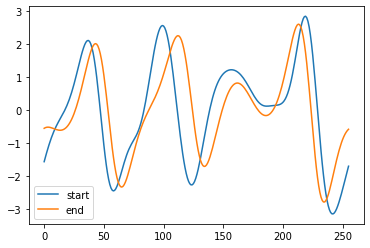

21: |F(x)| = 0.7882486454, |s| = 0.00578, |p| = 20.30756, |u| = 24.54780


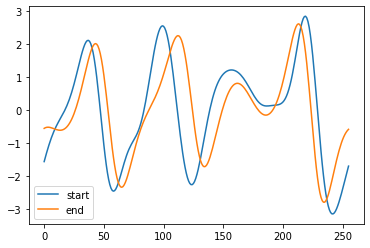

22: |F(x)| = 0.7860075756, |s| = 0.00580, |p| = 22.89305, |u| = 24.50054


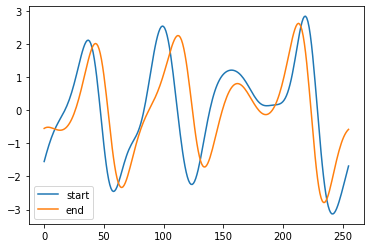

23: |F(x)| = 0.7838116958, |s| = 0.00581, |p| = 26.79206, |u| = 24.43985
Residual 0.13801888364161716


In [34]:
def numerical_jacobian(f,x,rdiff):
    fx = f(x)
    return lambda v: (f(x + rdiff * v.reshape(x.shape)) - fx)/rdiff

def JAX_newton_krylov(res, u0, tol=1e-5, iter=200):
    u = u0
    Jacobian_shape = (len(u0.flatten()), len(u0.flatten()))

    F = res(u)
    magF = np.linalg.norm(F)
    print(f"|F(x)| = {magF}")
    i = 1
    magold = magF
    conv = []
    shape = (len(u0.flatten()), len(u0.flatten()))
    s0 = 1e-2
    try: 
        while magF > tol and i < iter:
            J = linalg.LinearOperator(shape, matvec=numerical_jacobian(res,u,1e-5))
            p, errorcode = linalg.lgmres(J,F.flatten(),inner_m=40,outer_k=20)
            p = p.reshape(u.shape)
            s0 *= magold/magF
            s = s0
            while not jnp.linalg.norm(res(u - s*p)) < (1-0.01*s)*magF:
                s /= 2
            u -= s*p
            plt.plot(u,label='start')
            plt.plot(propagator(u,new_T), label='end')
            plt.legend()
            plt.show()
            F = res(u)
            magold = magF
            magF = np.linalg.norm(F)
            print(f"{i}: |F(x)| = {magF:.10f}, |s| = {s:.5f}, |p| = {np.linalg.norm(p):.5f}, |u| = {np.linalg.norm(u):.5f}")
            conv.append((magF, s, np.linalg.norm(p), np.linalg.norm(u)))
            i += 1
    except KeyboardInterrupt:
        pass
    return u, conv

# solve
guess = u[a] #State(u[a],new_T)
sol, conv = JAX_newton_krylov(residual,guess)
print('Residual', abs(residual(sol)).max())

In [ ]:
RPO = full_propagator(sol,new_T)

21.5


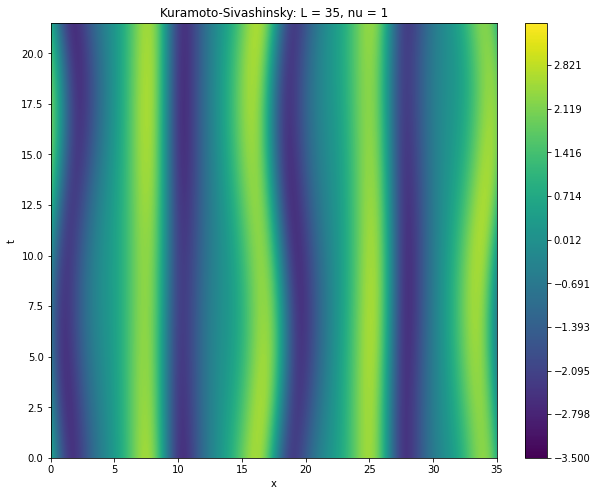

In [ ]:
print(new_T)
plot_KS(RPO, new_T)

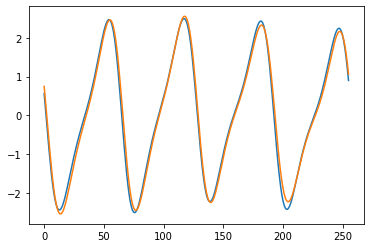

In [ ]:
plt.plot(RPO[0])
plt.plot(RPO[-1])

In [ ]:
diff = np.linalg.norm(RPO[:,np.newaxis] - RPO[np.newaxis,:],axis=-1)
X, Y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
diff[abs(X-Y)<0.1] += np.inf
a = np.argmin(diff) % nt
b = np.argmin(diff) // nt
a, b = min(a,b), max(a,b)
#plt.plot(RPO[a])
#plt.plot(RPO[b])
print(np.linalg.norm(RPO[a] - RPO[b]))
print(a,b)

c:\Users\kowal\miniconda3\envs\compphys\lib\site-packages\numpy\linalg\linalg.py:2560: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


nan
0 12


In [ ]:
T_new = new_T * (b-a)/nt
u_new = full_propagator(RPO[a],T_new)
#plot_KS(u_new, T_new)

In [ ]:
#plt.plot(u_new[0])
#plt.plot(u_new[-1])

|F(x)| = 469.8415734160163


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  from ipykernel import kernelapp as app


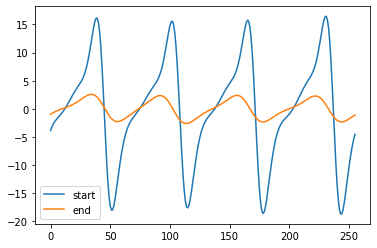

1: |F(x)| = 73.3063958423, |step| = 478.31850, |u| = 147.76012


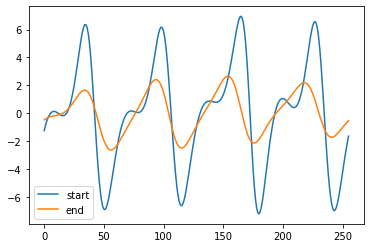

2: |F(x)| = 15.7162129956, |step| = 93.03453, |u| = 60.22850


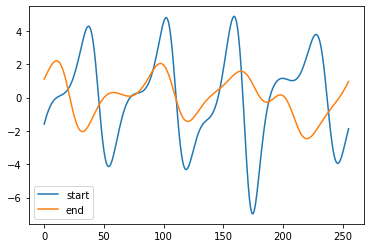

3: |F(x)| = 10.2122561141, |step| = 36.75494, |u| = 43.74468


KeyboardInterrupt: 

In [ ]:
@jit
def residual(u0):
    return u0 - propagator(u0,T_new)

# solve
guess = RPO[a] #State(u[a],new_T)
sol = JAX_newton_krylov(residual, guess)
print('Residual', abs(residual(sol)).max())

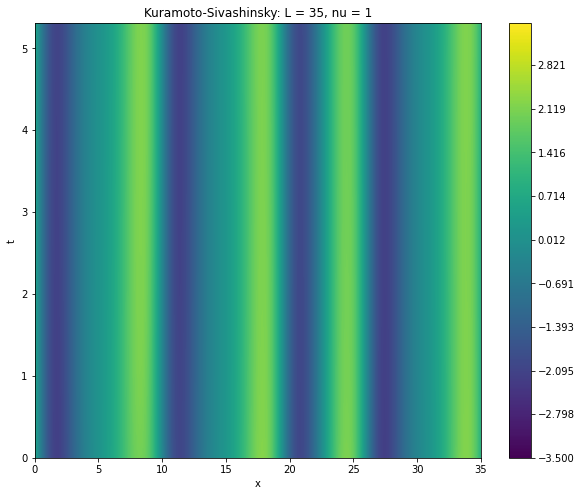

In [ ]:
RPO2 = full_propagator(sol,T_new)
#plot_KS(RPO2,T_new)

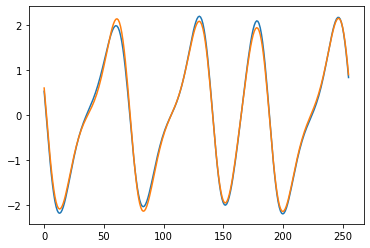

In [ ]:
plt.plot(RPO2[0])
plt.plot(RPO2[-1])